<a href="https://www.kaggle.com/code/muralidharanrajen/training-cnn-with-netcdfs-for-sea-temp-prediction?scriptVersionId=170440947" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

## Data Preperation

In [2]:
# List all the NetCDF files in the folder
file_pattern = "../input/netcdf/*.nc"

# Get the list of file paths
file_paths = sorted(glob.glob(file_pattern))

# Open multiple NetCDF files and concatenate along a new dimension
merged_data = xr.open_mfdataset(file_paths, concat_dim='ocean_time', combine='nested')['temp']

# Check the shape of the merged data
print(merged_data.values)
print(merged_data.shape)

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

### Normalize the values since it contains NaN

In [3]:
temp_tensor = torch.tensor(merged_data.values)
temp_norm_tensor = torch.nan_to_num(temp_tensor, nan=-50)
print(temp_norm_tensor)

tensor([[[-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         ...,
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.]],

        [[-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         ...,
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.]],

        [[-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         ...,
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.],
         [-50., -50., -50.,  ..., -50., -50., -50.]],

### Check the kth value to confirm the normalization

In [4]:
kth_min_value = torch.kthvalue(temp_norm_tensor.flatten(), 2000000).values
print(kth_min_value.item())

12.786829898785719


## Min-Max Normalization

normalized_value= ( ( (max_value − min_value) / (original_value − min_value) ) * 2 ) - 1

In [5]:
min_val = temp_norm_tensor.min()
max_val = temp_norm_tensor.max()
# normalized_tensor = (temp_norm_tensor - min_val) / (max_val - min_val) # range 0 to 1
normalized_tensor = 2 * ((temp_norm_tensor - min_val) / (max_val - min_val)) - 1 # range -1 to 1
print(normalized_tensor.shape)
print(normalized_tensor.min())
print(normalized_tensor.max())

torch.Size([10, 322, 706])
tensor(-1., dtype=torch.float64)
tensor(1., dtype=torch.float64)


## Other Normalization methods for reference

In [6]:
# Normalize using norm factor

# # Calculate the norm of the tensor
# norm = torch.norm(all_temp_norm_tensor)

# # Normalize the tensor
# normalized_tensor3 = all_temp_norm_tensor / norm

# # Print the original tensor and the normalized tensor
# print("Original Tensor:")
# print(all_temp_norm_tensor)
# print("\nNormalized Tensor:")
# print(normalized_tensor3)


# Z-score Normalization:

# mean = tensor.mean()
# std = tensor.std()
# normalized_tensor = (tensor - mean) / std


# L2 Normalization:

# import torch.nn.functional as F
# # Assuming tensor is your input tensor and dim is the dimension along which to compute the L2 norm
# normalized_tensor = F.normalize(tensor, p=2, dim=dim)


# Unit Vector Normalization:

# import torch.nn.functional as F
# # Assuming tensor is your input tensor and dim is the dimension along which to compute the L2 norm
# normalized_tensor = F.normalize(tensor, p=2, dim=dim)


# Mean Normalization:

# mean = tensor.mean()
# std = tensor.std()
# normalized_tensor = (tensor - mean) / std

# Choose the appropriate normalization method based on your specific requirements and the nature of your data.

## CNN model training

In [7]:
# Define your CNN model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # Define the layers of your CNN
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        # Add more convolutional layers as needed

    def forward(self, x):
        # Implement the forward pass
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        # Add more layers as needed
        return x

In [8]:
# Define your dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        inputs = sample[:10]  # Input data for the first 10 layers
        target = sample[10].unsqueeze(0)   # Target output for the 11th layer
        return inputs, target

In [9]:

# Create your dataset and dataloader
my_data = normalized_tensor  # Your time-averaged 3D numerical data
dataset = MyDataset(my_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize your model, loss function, and optimizer
model = MyCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train your model
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, target in dataloader:
#         inputs = batch.unsqueeze(1).float()  # Add channel dimension for grayscale data
        inputs = inputs.float()  # Convert inputs to float
#         print(f'input Shape: {inputs.shape}')
        target = target.float()  # Convert target to float
        target = target.transpose(0, 1) 
#         print(target.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)  # Unsqueeze target to match output shape
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

Epoch [1/100], Loss: 0.6928893327713013
Epoch [2/100], Loss: 0.5831011533737183
Epoch [3/100], Loss: 0.5069072842597961
Epoch [4/100], Loss: 0.4448337256908417
Epoch [5/100], Loss: 0.39021772146224976
Epoch [6/100], Loss: 0.33411872386932373
Epoch [7/100], Loss: 0.2841956317424774
Epoch [8/100], Loss: 0.25139936804771423
Epoch [9/100], Loss: 0.24710312485694885
Epoch [10/100], Loss: 0.26583951711654663
Epoch [11/100], Loss: 0.28167375922203064
Epoch [12/100], Loss: 0.28263744711875916
Epoch [13/100], Loss: 0.2721734642982483
Epoch [14/100], Loss: 0.2573941648006439
Epoch [15/100], Loss: 0.24448725581169128
Epoch [16/100], Loss: 0.23831568658351898
Epoch [17/100], Loss: 0.23686392605304718
Epoch [18/100], Loss: 0.23820599913597107
Epoch [19/100], Loss: 0.24031777679920197
Epoch [20/100], Loss: 0.2412496656179428
Epoch [21/100], Loss: 0.24000944197177887
Epoch [22/100], Loss: 0.23666000366210938
Epoch [23/100], Loss: 0.23328042030334473
Epoch [24/100], Loss: 0.23087069392204285
Epoch [25

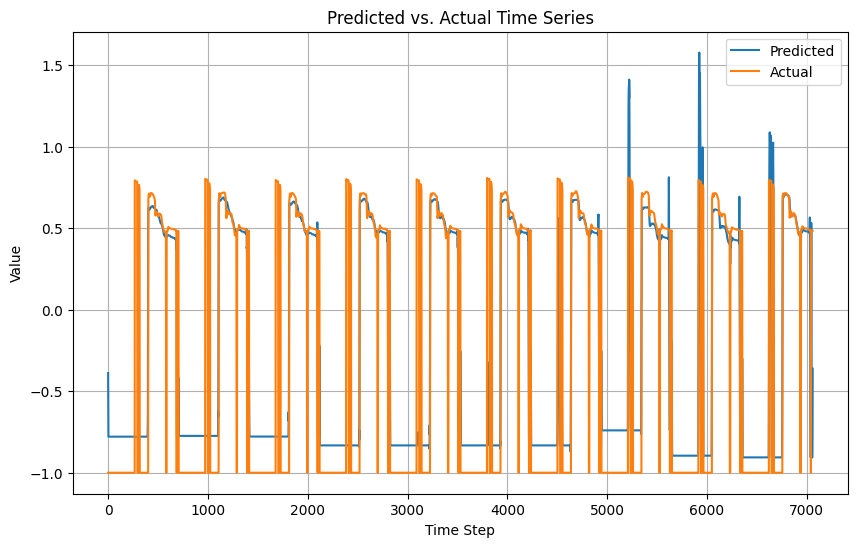

In [10]:
import matplotlib.pyplot as plt

# Assuming you have extracted predicted (preds) and target (targets) values for a sample

# Reshape if necessary (example for spatial dimensions)
preds = outputs.view(-1)  # Flatten if outputs have spatial dimensions
targets = target.view(-1)

# Create the time series plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(preds.detach().cpu(), label='Predicted')  # Detach and move to CPU for plotting
plt.plot(targets.detach().cpu(), label='Actual')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Time Series')
plt.legend()
plt.grid(True)
plt.show()

Need to adjust the shape of input and targets to visualize the output properly. will be updated soon.

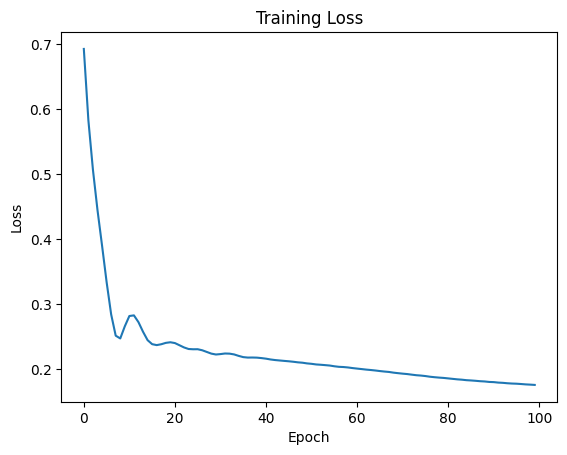

torch.Size([10, 10, 706])
torch.Size([10, 1, 706])
torch.Size([1, 10, 706])


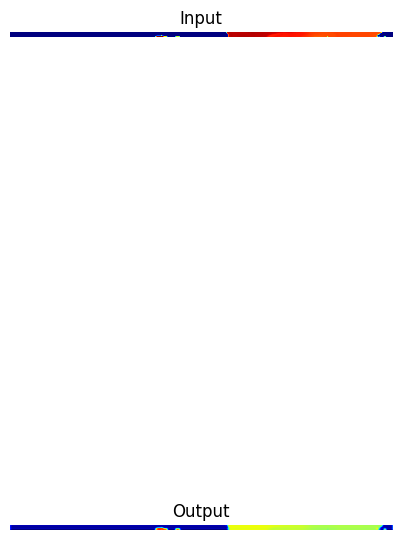

In [11]:
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Visualize some sample input and output
sample_inputs, sample_target = next(iter(dataloader))
sample_inputs = sample_inputs.float()
sample_output = model(sample_inputs)
print(sample_inputs.shape)
print(sample_target.shape)
print(sample_output.shape)
plt.figure(figsize=(20, 10))
for i in range(1):  # Visualize 5 samples
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_inputs[i].numpy(), cmap='jet')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(sample_output[i].detach().numpy(), cmap='jet')
    plt.title('Output')
    plt.axis('off')
plt.tight_layout()
plt.show()